# 1/2Q gates on two coupled fixed transmons with parametric charge-charge coupling

In this notebook, we consider a system of two fixed frequency transmons with a coupling via the charge operator (corresponds to dipole-dipole capacitive coupling). We assume that we can apply a paramteric drive on the coupling term. We will show single qubit gates and also tune up a CZ on this system and show that it's quite sensitive to static ZZ coupling.

The Hamiltonian of the system is:

$$
H = E_{c1}(\hat{n}_1 -n_{g1})^2 - E_{J1}\cos(\hat{\phi}_1) + E_{c2}(\hat{n}_1 -n_{g2})^2 - E_{J2}\cos(\hat{\phi}_2) \\
+ g_1 v_{d1}(t) \hat{n}_1  + g_2 v_{d2}(t) \hat{n}_2  \\
+ g_{12}(1+v_{p})(t)\hat{n}_1\hat{n}_2.
$$

Here $\hat{n}_i$ are operators for the number of Cooper pairs on the transmon island, $\hat{\phi}_i$ are operators for the phase across the JJ, $v_{di}$ are (normalized) single qubit drive pulses, and $v_{p}$ is a paramteric drive pulse.

The first question we would like to answer is how can we see that we obtain here the interaction we want in order to perform a CZ. In order to answer this, let's look at the $\hat{n}_1\hat{n}_2$ in the energy eigenbasis. As we will see, in this basis the number operators couple between states whose index defer by one, so each number operator looks roughly like this:

$$
\hat{n}_i \simeq \ket{0}\bra{1} + \ket{1}\bra{2} + \dots + \rm{h.c}
$$

so the combined operator will have the following terms:

$$
\hat{n}_1\hat{n}_2 \simeq \ket{00}\bra{11} + \ket{01}\bra{10} + \ket{02}\bra{11} + \dots + \rm{h.c}
$$

The two most interesting terms are $\ket{01}\bra{10}$ that provides an iSWAP interaction, and $ \ket{02}\bra{11} + \rm{h.c}$ that provides a CZ interaction.

In the frame rotating with the dressed qubit energies, these terms will oscillate, and the interaction term will look like this:

$$
g_{12}(1+v_{p})(t)(\ket{02}\ket{11}\exp(-i(\omega_{02} - \omega_{11})t) + \rm{h.c}),
$$

and so we will need a paramteric drive at the corresponding $\omega_{02} - \omega_{11}$ frequency to be on resonance with this interaction. This is what we show in what follows.

## Choosing the qubit parameters

1. need to make sure 11 and 02/20 are not too close
2. need to make sure that g is not too big which can make the static ZZ coupling very large
3. need to make sure that the qubits are far enough in frequency so that static ZZ is not too large

In [27]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
from qutip.qip.operations import rz, cz_gate
import cmath


def generate_hilbertspace(EJ1, EC1, EJ2, EC2, g_strength):
    tmon1 = scq.Transmon(
        EJ=EJ1,
        EC=EC1,
        ng=0.0,
        ncut=31,
        truncated_dim=3

    )

    tmon2 = scq.Transmon(
        EJ=EJ2,
        EC=EC2,
        ng=0.0,
        ncut=31,
        truncated_dim=3
    )

    # define the common Hilbert space
    hilbertspace = scq.HilbertSpace([tmon1, tmon2])

    # add interaction between two qubits
    hilbertspace.add_interaction(
        g_strength=g_strength,
        op1=tmon1.n_operator,
        op2=tmon2.n_operator,
    )

    # generate spectrum lookup table
    hilbertspace.generate_lookup()
    return tmon1, tmon2, hilbertspace


g_strength = 0.02
tmon1, tmon2, hilbertspace = generate_hilbertspace(21, 0.25, 25, 0.25, g_strength)

bare_indices = [hilbertspace.bare_index(i) for i in range(9)]
qutip_indices = [(i1, i2) for i1 in range(3) for i2 in range(3)]

## Energy level diagram

We first plot the energy levels ladder, and zoom in on the 11/02/20 region because this is where most shifts from the static occur, and also importantly it shows the static ZZ shift.

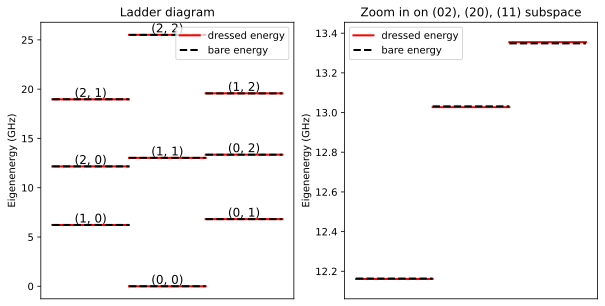

In [28]:
energies = hilbertspace.eigenvals(evals_count=hilbertspace.dimension)
ground_energy = hilbertspace.eigenvals(evals_count=1)[0]

bare_energies = [e1 + e2 for e1 in tmon1.eigenvals(evals_count=3) for e2 in tmon2.eigenvals(evals_count=3)]
ground_energy_bare = bare_energies[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(hilbertspace.dimension):
    bare_ind = hilbertspace.bare_index(i)

    energy = energies[i] - ground_energy
    horizontal_pos = 2*np.argmax(bare_ind) if bare_ind[0] != bare_ind[1] else 1
    label = 'dressed energy' if i == 0 else None
    for ax in axes:
        ax.plot([horizontal_pos, horizontal_pos + 1], [energy, energy], color='r', lw=2, label=label)
    axes[0].text(horizontal_pos+0.5, energy, f"{bare_ind}", ha='center', va='bottom', fontsize=12)

for i in range(hilbertspace.dimension):
    qutip_ind = qutip_indices[i]
    energy_bare = bare_energies[i] - ground_energy_bare
    horizontal_pos = 2*np.argmax(qutip_ind) if qutip_ind[0] != qutip_ind[1] else 1
    label = 'bare energy' if i == 0 else None
    for ax in axes:
        ax.plot([horizontal_pos, horizontal_pos + 1], [energy_bare, energy_bare], 'k--', lw=2, label=label)

        ax.set_xticks([])
        ax.set_ylabel('Eigenenergy (GHz)')
        ax.legend()
    axes[0].set_title('Ladder diagram')
    lim_energies = np.array([hilbertspace.energy_by_bare_index(bare_ind) for bare_ind in [(0, 2), (2, 0), (1, 1)]]) - ground_energy
    axes[1].set_ylim(min(lim_energies) - 0.1, max(lim_energies) + 0.1)
    axes[1].set_title('Zoom in on (02), (20), (11) subspace')


### Summary of transmon system parameters

In [31]:
print('bare parameters\n----------------')
print(f'tmon1 anharmonicity = {tmon1.anharmonicity():.4f} GHz')
print(f'tmon2 anharmonicity = {tmon2.anharmonicity():.4f} GHz')
print(f'tmon1 E01 = {tmon1.E01():.4f} GHz')
print(f'tmon2 E01 = {tmon2.E01():.4f} GHz')
print(f'tmon1 E01 - tmon2 E01 = {tmon2.E01() - tmon1.E01():.4f} GHz')

print(f'\ndressed parameters (g = {g_strength*1e3:.2f} MHz)\n------------------------------')
f00_10 = hilbertspace.energy_by_bare_index((1, 0)) - hilbertspace.energy_by_bare_index((0, 0))
print(f'{f00_10=:.3f} GHz')
f00_01 = hilbertspace.energy_by_bare_index((0, 1)) - hilbertspace.energy_by_bare_index((0, 0))
print(f'{f00_01=:.3f} GHz')
f11_20 = hilbertspace.energy_by_bare_index((2, 0)) - hilbertspace.energy_by_bare_index((1, 1))
print(f'{f11_20=:.3f} GHz')
f11_02 = hilbertspace.energy_by_bare_index((0, 2)) - hilbertspace.energy_by_bare_index((1, 1))
print(f'{f11_02=:.3f} GHz')
static_ZZ = hilbertspace.energy_by_bare_index((1, 1)) - hilbertspace.energy_by_bare_index((0, 1)) - hilbertspace.energy_by_bare_index((1, 0)) + hilbertspace.energy_by_bare_index((0, 0))
print(f'static ZZ = {static_ZZ*1e3:.6f} MHz')
print(f'E10 shift = {1e3*(tmon1.E01() - f00_10):.4f} MHz')
print(f'E01 shift = {1e3*(tmon2.E01() - f00_01):.4f} MHz')


bare parameters
----------------
tmon1 anharmonicity = -0.2766 GHz
tmon2 anharmonicity = -0.2739 GHz
tmon1 E01 = 6.2200 GHz
tmon2 E01 = 6.8113 GHz
tmon1 E01 - tmon2 E01 = 0.5913 GHz

dressed parameters (g = 20.00 MHz)
------------------------------
f00_10=6.218 GHz
f00_01=6.813 GHz
f11_20=-0.866 GHz
f11_02=0.328 GHz
static ZZ = -3.967074 MHz
E10 shift = 1.8623 MHz
E01 shift = -1.7070 MHz


## States and operators 

Below we plot the weight of the bare states in the dressed state, indexed by the original bare states. We can see that bevcause 02 and 11 are so close, we will get a significant weight of one in the other. For other states it's not the case.

In [32]:
dressed_to_qutip = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in qutip_indices] 
qutip_to_dressed = [dressed_to_qutip.index(i) for i in range(9)]

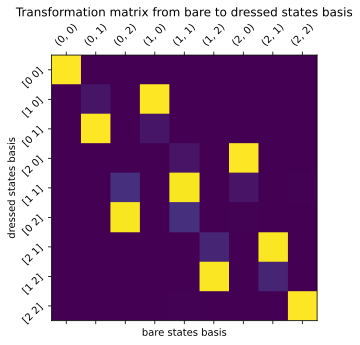

In [33]:
eigs = hilbertspace.eigensys(evals_count=9)[1]
tmat = [eigs[i].full() for i in range(9)]
tmat = np.squeeze(tmat)
tmat = qt.Qobj(tmat, dims=[[3, 3], [3, 3]])
tmat

fig, ax = plt.subplots()
ax.matshow(np.abs(tmat.full()))
ax.set_xticks(range(9))
ax.set_xticklabels(qutip_indices, rotation=45)
ax.set_xlabel('bare states basis')
ax.set_yticks(range(9))
ax.set_yticklabels(np.array(qutip_indices)[qutip_to_dressed], rotation=45)
ax.set_title('Transformation matrix from bare to dressed states basis')
ax.set_ylabel('dressed states basis');

In [36]:
# get the representation of the n_1, n_2, interaction operators in the dressed eigenbasis of the composite system
# note that these are in the dressed basis
n_1 = hilbertspace.op_in_dressed_eigenbasis(op=tmon1.n_operator)  
n_2 = hilbertspace.op_in_dressed_eigenbasis(op=tmon2.n_operator) 

# this is given in the bare basis, and we need to transform it to the dressed basis
interaction_term = hilbertspace.interaction_hamiltonian()  
interaction_term = tmat * interaction_term * tmat.dag()

# note that equivalently we could have just defined it explicitly using the dressed basis number operators
assert np.max(np.abs((g_strength*n_1*n_2 - interaction_term).full())) < 1e-16

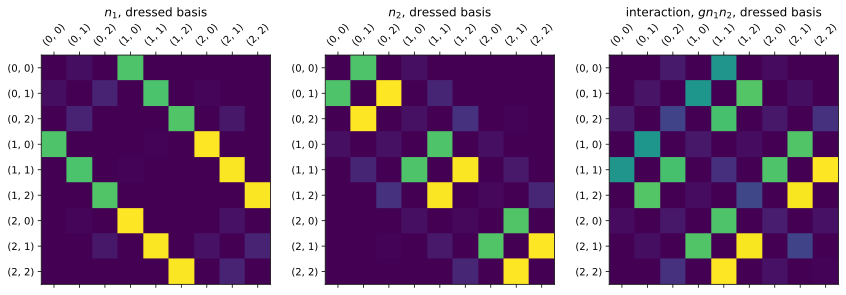

In [44]:
indices = qutip_indices
# plot n_1, n_2 as a matrix plot, with indices given by the qutip indices

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

mat_to_plot = [np.abs(n_1.full()), np.abs(n_2.full()), np.abs(interaction_term.full())]

for ax, mat in zip(axes, mat_to_plot):
    mat = mat[dressed_to_qutip, :]
    mat = mat[:, dressed_to_qutip]
    ax.matshow(mat)
    ax.set_xticks(range(9))
    ax.set_xticklabels(indices, rotation=45)
    ax.set_yticks(range(9))
    ax.set_yticklabels(indices)

axes[0].set_title(r'$n_1$, dressed basis')
axes[1].set_title(r'$n_2$, dressed basis')
axes[2].set_title(r'interaction, $gn_1n_2$, dressed basis')

fig.tight_layout()

In [39]:
states = [qt.basis(hilbertspace.dimension, idx) for idx in dressed_to_qutip]

# The computational subspace is spanned by the first 4 states
computational_subspace = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in [(0, 0), (1, 0), (0, 1), (1, 1)]]


def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_bare_index(s1)
            - hilbertspace.energy_by_bare_index(s0)
        )
        * 2
        * np.pi
    )


def get_drive_hamiltonian(drive_term, transitions, tg, rot_angle, verbose=False):
    """ 
    Returns the time-dependent Hamiltonian for driving a transition between two states in the dressed basis.
    The ordering of the indices is dressed order, not qutip order.
    """

    omega_drive = transition_frequency(*transitions)

    # Gaussian pulse parameters optimized by hand
    A = 1 / tg / np.abs(drive_term[bare_indices.index(transitions[0]), bare_indices.index(transitions[1])])
    if verbose:
        print(f'drive freq = {omega_drive/(2*np.pi):.4f} GHz')
        print(f'{A=:.3f} GHz')
        print(f'{tg=:.3f} ns')

    #Gaussian pulse envelope
    def drive_coeff(t: float, args: dict) -> float:
        if 0 < t and t < 2*tg:
            return A * np.exp(-8 * (t - tg)**2 / tg**2) / (0.5*np.sqrt(np.pi/2)) * np.cos(omega_drive * t)
            # return A * np.cos(omega_drive * t)
        else:
            return 0

    # Hamiltonian in dressed eigenbasis
    (evals,) = hilbertspace["evals"]
    # The factor of 2pi converts the energy to GHz so that the time is in units of ns
    diag_dressed_hamiltonian = (
            2 * np.pi * qt.Qobj(np.diag(evals),
            dims=[hilbertspace.subsystem_dims] * 2)
    )

    # time-dependent drive Hamiltonian
    H_qbt_drive = [
        diag_dressed_hamiltonian,
        [rot_angle*drive_term, drive_coeff],  # driving through the resonator
    ]
    return H_qbt_drive



# Drive Visualization

## single qubit drive on q1

Text(0.5, 0, 't (ns)')

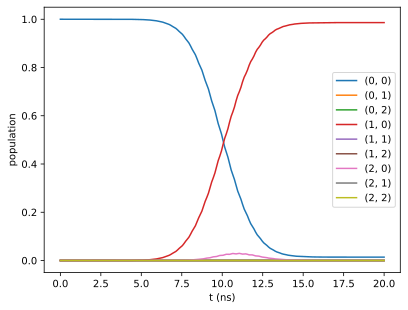

In [40]:
from qutip.solver import Options

drive_term = n_1
transitions = [(0, 0), (1, 0)]
tg = 10  # ns

H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=np.pi)

# array of time list
tlist = np.linspace(0, 2*tg, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    states[0],
    tlist,
    e_ops=[state * state.dag() for state in states],
    options=Options(nsteps=10000)
)

for idx, res in zip(dressed_to_qutip, result.expect):
    plt.plot(tlist, res, label=hilbertspace.bare_index(idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")

## single qubit drive on q2

Text(0.5, 0, 't (ns)')

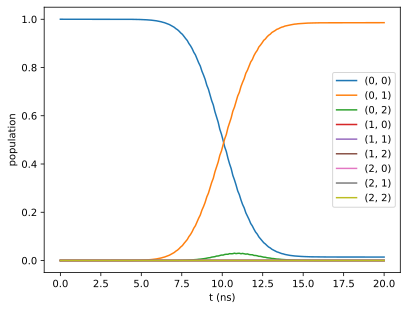

In [41]:
from qutip.solver import Options

drive_term = n_2
transitions = [(0, 0), (0, 1)]
tg = 10  # ns

H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=np.pi)

# array of time list
tlist = np.linspace(0, 2*tg, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    states[0],
    tlist,
    e_ops=[state * state.dag() for state in states],
    options=Options(nsteps=10000)
)

for idx, res in zip(dressed_to_qutip, result.expect):
    plt.plot(tlist, res, label=hilbertspace.bare_index(idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")

## CZ gate: 11 through 02

Text(0.5, 0, 't (ns)')

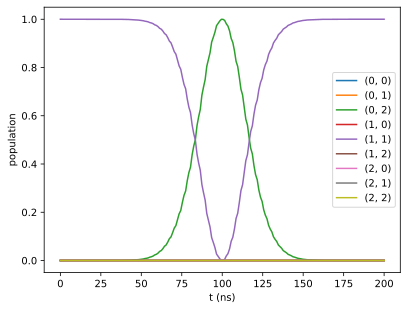

In [42]:
from qutip.solver import Options

drive_term = interaction_term
transitions = [(1, 1), (0, 2)]
tg = 100  # ns

H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=2*np.pi)

# array of time list
tlist = np.linspace(0, 2*tg, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive,
    states[4],
    tlist,
    e_ops=[state * state.dag() for state in states],
    options=Options(nsteps=10000)
)

for idx, res in zip(dressed_to_qutip, result.expect):
    plt.plot(tlist, res, label=hilbertspace.bare_index(idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")

## Propagator calculation for CZ

In [251]:
# Factor global phase so that upper-left corner of matrix is real
def remove_global_phase(op):
    return op * np.exp(-1j * cmath.phase(op[0, 0]))


def dphi(prop, state):
    return -np.angle(prop.full()[state, state]) + np.angle(
        prop.full()[0, 0]
    )

In [252]:
from qutip.solver import Options
from tqdm import tqdm
drive_term = interaction_term
transitions = [(1, 1), (0, 2)]
tgvec = np.linspace(20, 40, 6)
phi_11 = []
phi_00 = []
phi_01 = []
phi_10 = []
leakage = []
rot_angle_vec = np.array([0, 2*np.pi])

for tg in tqdm(tgvec):
    leakage.append([])
    phi_11.append([])
    for rot_angle in rot_angle_vec:

        # print(f'{tg=:.3f} ns')
        H_qbt_drive = get_drive_hamiltonian(drive_term, transitions, tg, rot_angle=rot_angle)

        # array of time list
        tlist = np.linspace(0, 2*tg, 100)  # total time

        # get the propagator at the final time step
        prop = qt.propagator(H_qbt_drive, tlist, options=Options(nsteps=2000))[-1]  

        # truncate the propagator to the computational subspace
        Uc = qt.Qobj(
            [
                [prop.full()[s1, s2] for s1 in computational_subspace]
                for s2 in computational_subspace
            ]
        )
        remove_global_phase(Uc)

        # product of single-qubit Z-gates
        ind01 = hilbertspace.dressed_index((0, 1))
        ind10 = hilbertspace.dressed_index((1, 0))
        ind11 = hilbertspace.dressed_index((1, 1))
        ind02 = hilbertspace.dressed_index((0, 2))
        ind20 = hilbertspace.dressed_index((2, 0))
        Uz = remove_global_phase(qt.tensor(rz(dphi(prop, ind01)), rz(dphi(prop, ind10))))
        Uc_reshaped = qt.Qobj(Uc.data, dims=[[2, 2], [2, 2]])
        Ucprime = remove_global_phase(Uz * Uc_reshaped)

        phi_11[-1].append(np.angle(Ucprime[3, 3]))
        leakage[-1].append(np.abs(prop[ind11, ind02]))
        # print('leakage = ', leakage[-1])
        # print('phi_11 = ', phi_11[-1]/np.pi)
        # print('phi_00 = ', phi_00[-1]/np.pi)
        # print('phi_01 = ', phi_01[-1]/np.pi)
        # print('phi_10 = ', phi_10[-1]/np.pi)


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


In [253]:
# extrapolate to tg = 0 using polyfit

phifit = np.polyfit(tgvec, np.unwrap(phi_11), 1)
t_extrap = np.linspace(0, 40, 100)


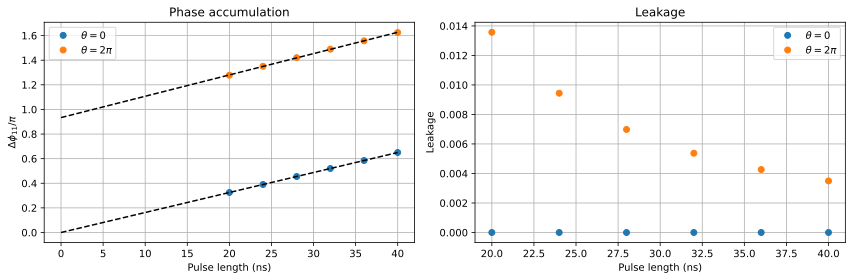

In [255]:
# plot phi_11 and leakage side by side

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(tgvec, np.unwrap(np.array(phi_11))/np.pi, 'o')
ax[0].plot(t_extrap, np.polyval(phifit[:, 0], t_extrap)/np.pi, 'k--')
ax[0].plot(t_extrap, np.polyval(phifit[:, 1], t_extrap)/np.pi, 'k--')
ax[0].grid(which='both')
ax[0].set_xlabel('Pulse length (ns)')
ax[0].set_ylabel(r'$\Delta\phi_{11}/\pi$')
ax[0].set_title('Phase accumulation')
ax[0].legend([r'$\theta=0$', r'$\theta=2\pi$'])
ax[1].plot(tgvec, leakage, 'o')
ax[1].grid(which='both')
ax[1].set_xlabel('Pulse length (ns)')
ax[1].set_ylabel('Leakage')
ax[1].set_title('Leakage')
ax[1].legend([r'$\theta=0$', r'$\theta=2\pi$'])

fig.tight_layout()

In [109]:
#fidelity measure given on page 3 of Nesterov et al.
((Ucprime.dag() * Ucprime).tr() + np.abs((Ucprime.dag() * cz_gate()).tr()) ** 2) / 20

0.6812993720784396